In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 二項分布モデル：複数の標本

- 標本が二つ(n,kのペアが2セット)ある場合に、共通のパラメータを推論する

## 問題設定

- 共通のパラメータを持つ二項分布から、二つの標本を取得
- 二項分布のパラメータを推論する

## データ

In [2]:
ns = [10, 10]
ks = [5, 7]

## 推論（PyMC）

### モデル定義

In [3]:
with pm.Model() as model:
    theta = pm.Beta('theta', 1, 1)

    for i, (n, k) in enumerate(zip(ns, ks)):
        y = pm.Binomial(f'y_{i}', p=theta, n=n, observed=k)

### 推論

In [4]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [theta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

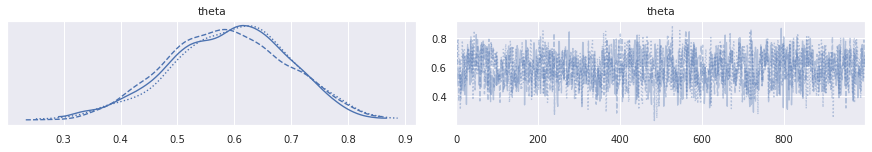

In [5]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'theta'}>], dtype=object)

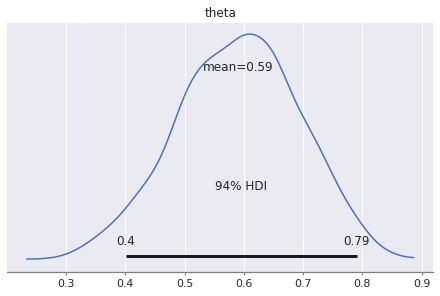

In [6]:
pm.plot_posterior(trace)

## 推論（Pyro）

### モデル定義

In [7]:
def model_binom(params=None):
    theta = pyro.sample('theta', dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    y = pyro.sample('y', dist.Binomial(total_count=n, probs=theta))
    return y

cond_model = pyro.condition(
    model_binom, 
    data={'y':torch.tensor(ks).float(), 
          'n':torch.tensor(ns).float()})

### 推論

In [8]:
nuts_kernel = infer.NUTS(cond_model, 
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1000,
                  warmup_steps=500,
                  num_chains=1)

mcmc.run()

Sample: 100%|██████████| 1500/1500 [00:05, 286.83it/s, step size=9.99e-01, acc. prob=0.927]


### 推論結果の確認

In [9]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.59      0.10      0.59      0.42      0.74    338.27      1.00

Number of divergences: 0


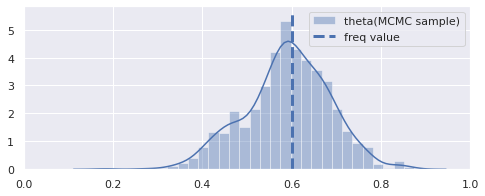

In [10]:
theta_sample_mcmc = mcmc.get_samples()['theta']

fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
sns.distplot(theta_sample_mcmc, ax=ax, label='theta(MCMC sample)')

xmin, xmax, ymin, ymax = ax.axis()
ax.vlines(sum(ks)/sum(ns), ymin, ymax, linestyles='dashed', lw=3, label='freq value')

ax.set_xlim(0, 1)
ax.legend()